## Chapter 6: First order methods

# 6.6  First order coordinate descent methods

In this Section we discuss first order coordinate descent methods, which are the first order analogs of the zero order methods introduced in Section 5.5 where the entire concept of a coordinate descent approach was first introduced.  Both the first order optimality condition as well as gradient descent were designed to minimize a function $g\left(w_1,w_2,...,w_N\right)$ with respect to all of its parameters *simultaneously*.  Here we examine the power of minimizing such a function one coordinate / weight - or one subset of coordinates / weights - at a time employing our first order optimization tools.  

This simple idea of combining the coordinate-wise approach with first order technologies can be extended in a variety of ways that are extremely popular in machine learning.  First order coordinate descent approaches are widely used optimization method for a number of machine learning problems (as we will see in later Chapters) including boosting methods for nonlinear supervised learning, K-Means clustering, nonnegative matrix factorization problems, recommender systems and general matrix factorization problems.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# import standard tools
import sys
sys.path.append('../../')
import autograd.numpy as np
import time
import copy

# import custom plotting tools
from mlrefined_libraries import math_optimization_library as optlib
static_plotter = optlib.static_plotter.Visualizer();
anime_plotter = optlib.animation_plotter.Visualizer();

# the next three lines are needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

## 6.6.1  Coordinate descent and the first order optimality condition

As we saw in Section 6.1 the first order optimality condition is a powerful but rather theoretical way of characterizing the minima of a function.  In particular it tells us that - for a given cost function $g\left(\mathbf{w}\right)$ taking in $N$ dimensional input - that the stationary points (minima included) of this function are those satisfying the system of equations

\begin{equation}
\nabla g\left(\mathbf{v}\right)=\mathbf{0}_{N\times1}
\end{equation}

or written out one equation at-a-time as

\begin{equation}
\begin{array}
\
\frac{\partial}{\partial w_{1}}g(\mathbf{v})=0\\
\frac{\partial}{\partial w_{2}}g(\mathbf{v})=0\\
\,\,\,\,\,\,\,\,\,\,\vdots \\
\frac{\partial}{\partial w_{N}}g(\mathbf{v})=0.
\end{array}
\end{equation}

If this set of equations can be solved we can then potentially recover minimum points of $g$.  Indeed - as we have seen - this is what gradient descent (and all local optimization methods) are indirectly doing.  However we can rarely solve this system directly in practice 'by hand' (see Section 6.1 for some important exceptions).   Moreover even when these equations are linear - while we can write out the algebraic form of the solution - we still need an algorithm to actually resolve the solution to such a system in a timely manner. 

However if we take a 'coordinate-wise' view of things, we can simplify the task of solving first order systems by solving just one of these equations (or - more generally - one batch of the equations) at a time resulting in a coordinate descent scheme.  This turns the often impossible task of solving a fir
st order systems *simultaneously* into a coordinate-wise approach where we solve them *sequentially*.  That is, instead of trying to solve the system of equations all at once we solve each partial derivative equation

\begin{equation}
\frac{\partial}{\partial w_{n}}g(\mathbf{v})=0
\end{equation}

one at-a-time.  Hence this idea will be especially effective when each such equation of a first order system can be solved for in closed form.  

To perform coordinate descent using this idea we first initialize at an input point $\mathbf{w}^0$, and begin by updating the first coordinate

\begin{equation}
\frac{\partial}{\partial w_{1}}g\left(\mathbf{w}^0\right)=0 
\end{equation}

for the optimal first weight $w_1^{\star}$.  We then update the first coordinate of the vector $\mathbf{w}^0$ with this solution, and call the updated set of weights $\mathbf{w}^1$.  Continuing this pattern to update the $n^{th}$ weight we solve

\begin{equation}
\frac{\partial}{\partial w_{n}}g\left(\mathbf{w}^{n-1}\right)=0 
\end{equation}

for $w_n^{\star}$, and update the $n^{th}$ weight using this value forming the updated set of weights $\mathbf{w}^n$.  

After we sweep through all $N$ weights a single time we can refine our solution by sweeping through the weights again (as with any other coordinate wise method).  At the $k^{th}$ such sweep we update the $n^{th}$ weight by solving the single equation

\begin{equation}
\frac{\partial}{\partial w_{n}}g\left(\mathbf{w}^{k + n-1}\right)=0 
\end{equation}

and update the $n^{th}$ weight of $\mathbf{w}^{k + n-1}$, and so on.

Notice that this is indeed a local optimization method we have detailed here.  We did not write out the sequence of updates above in the familiar local optimization format of

\begin{equation}
\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha \mathbf{d}^{k}
\end{equation}

because each update is more naturally written as the solution to a partial derivative equation.  However we could very well express the updates like this.  In particular on the $k^{th}$ sweep we can express the $n^{th}$ update above equivalently as

\begin{equation}
\mathbf{w}^{k+n} = \mathbf{w}^{k+n-1} + \alpha \mathbf{e}_n
\end{equation}

where $\mathbf{e}_n$ is the $n^{th}$ standard basis element and $\alpha = \left(w_n^{\star} - w_n^{k+n-1}\right)$ where $w_n^{\star}$ is the solution to equation (6).  So - in other words - this is a coordinate descent method akin to the zero-order method discussed in Section 5.5 only here we have used calculus (and the first order optimality condition in particular) to automatically tune the steplength $\alpha$ at each step.

Below we summarize this first order coordinate descent algorithm in pseudo-code, followed by a number of examples of its implementation.

### Coordinate descent algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>Input:</strong> cost function $g\left(\mathbf{w}\right)$, initial point $\mathbf{w}^0$, maximum number of steps $K$, set $\mathbf{w}_{\text{best}} = \mathbf{w}^0$ <br>


<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,k = 1...K$<br>


<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $n=1...N$ <br>


<strong>4:
</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve</code> $
\frac{\partial}{\partial w_{n}}g(\mathbf{w}^{k + n -1})=0
$ for $w_n^{\star}$

<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\,$ call  $\mathbf{w}^{k + n} = \mathbf{w}^{k + n-1}$, where $w_n^{k + n} \longleftarrow w_n^{\star}$ <br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>if</code> $g\left(\mathbf{w}^{k + n}\right) < g\left(\mathbf{w}^{k + n-1}\right)$  <br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{w}^{k + n-1} \longleftarrow \mathbf{w}^{k + n}$<br>

<strong>9:</strong>&nbsp;&nbsp; <strong>output:</strong> history of weights $\left\{\mathbf{w}^{b}\right\}_{b=0}^{KN}$ and corresponding function evaluations $\left\{g\left(\mathbf{w}^{b}\right)\right\}_{b=0}^{KN}$ <br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>


#### <span style="color:#a50e3e;">Example 1:</span>  Minimizing convex quadratic functions via first order coordinate descent

In this example we develop the coordinate descent for minimizing a convex quadratic function

\begin{equation}
g\left(\mathbf{w}\right)=a + \mathbf{b}^{T}\mathbf{w} + \mathbf{w}^{T}\mathbf{C}\mathbf{w}
\end{equation}

In practice we almost never care about finding the minimum of a function that dips down to negative infinity, so in keeping with this we will assume that the quadratic is convex (this means that the matrix $\mathbf{C}$ is both symmetric and has all nonnegative eigenvalues.

In Section 6.1 we saw that the first order system for a general quadratic is given as

\begin{equation}
\nabla g(\mathbf{w}) = 2\mathbf{C}\mathbf{w} + \mathbf{b} = \mathbf{0}_{N\times 1}
\end{equation}

or if we write out the system equation-wise

\begin{equation}
\begin{array}
\
\frac{\partial}{\partial w_{1}}g(\mathbf{w})= 2\left(c_{11}w_1 + c_{12}w_2 + c_{13}w_3 +  \cdots + c_{1N}w_N\right) + b_1 = 0\\
\frac{\partial}{\partial w_{2}}g(\mathbf{w})=2\left(c_{21}w_1 + c_{22}w_2 + c_{23}w_3 + \cdots + c_{2N}w_N\right) + b_2 = 0\\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\vdots \\
\frac{\partial}{\partial w_{N}}g(\mathbf{w})=2\left(c_{N1}w_1 + c_{N2}w_2 + c_{N3}w_3 +  \cdots + c_{NN}w_N\right) + b_N = 0.
\end{array}
\end{equation}

Solving the $n^{th}$ equation for $w_n$ gives

\begin{equation}
w_n = -\frac{c_{n1}^{\,}w_1 + c_{n2}^{\,}w_2 + \cdots + c_{nN}^{\,}w_N + \frac{1}{2}b_n^{\,}}{c_{nn} }
\end{equation}

In the next Python cell we implement this update scheme in Python in the function ``coordinate_descent_for_quadratic``.  This Python function takes in the constants of a quadratic ($a$, $\mathbf{b}$, and $\mathbf{C}$) and outputs a weight history at each individual weight update.  This is done so that we can visualize the resulting cost function decrease in a variety of ways.  In practice one need not record the weights at each weight update but e.g., the weights after each sweep through the coordinates, or the weight corresponding to the lowest cost function value attained thus far.

In [27]:
def coordinate_descent_for_quadratic(g,w,max_its,a,b,C):
    '''
    Coordinate descent wrapper for general quadratic function. Here
    
    a - a constant
    b - an Nx1 vector
    C - an NxN matrix (symmetric and all nonnegative eigenvalues)
    '''
        
    # record weights and cost history 
    weight_history = [copy.deepcopy(w)]     
    cost_history = [g(w)]
    N = np.size(w)
    
    # outer loop - each is a sweep through every variable once
    for k in range(max_its):
        # inner loop - each is a single variable update
        for n in range(N):
            w[n] = -(np.dot(C[n,:],w) - C[n,n]*w[n] + 0.5*b[n])/float(C[n,n])
            
            # record weights and cost value at each step
            weight_history.append(copy.deepcopy(w))
            cost_history.append(g(w))

    return weight_history,cost_history

First we use this algorithm to minimize the simple quadratic 

\begin{equation}
g(w_0,w_1) = w_0^2 + w_1^2 + 2
\end{equation}

which can be written in vector-matrix where $a = 2$, $\mathbf{b} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$, and $\mathbf{C} = \begin{bmatrix} 1 \,\, 0 \\ 0 \,\, 1 \end{bmatrix}$.  We initialize at $\mathbf{w} = \begin{bmatrix} 3 \\ 4 \end{bmatrix}$ and run $1$ iteration of the algorithm - that is all it takes to perfectly minimize the function.

<IPython.core.display.Javascript object>


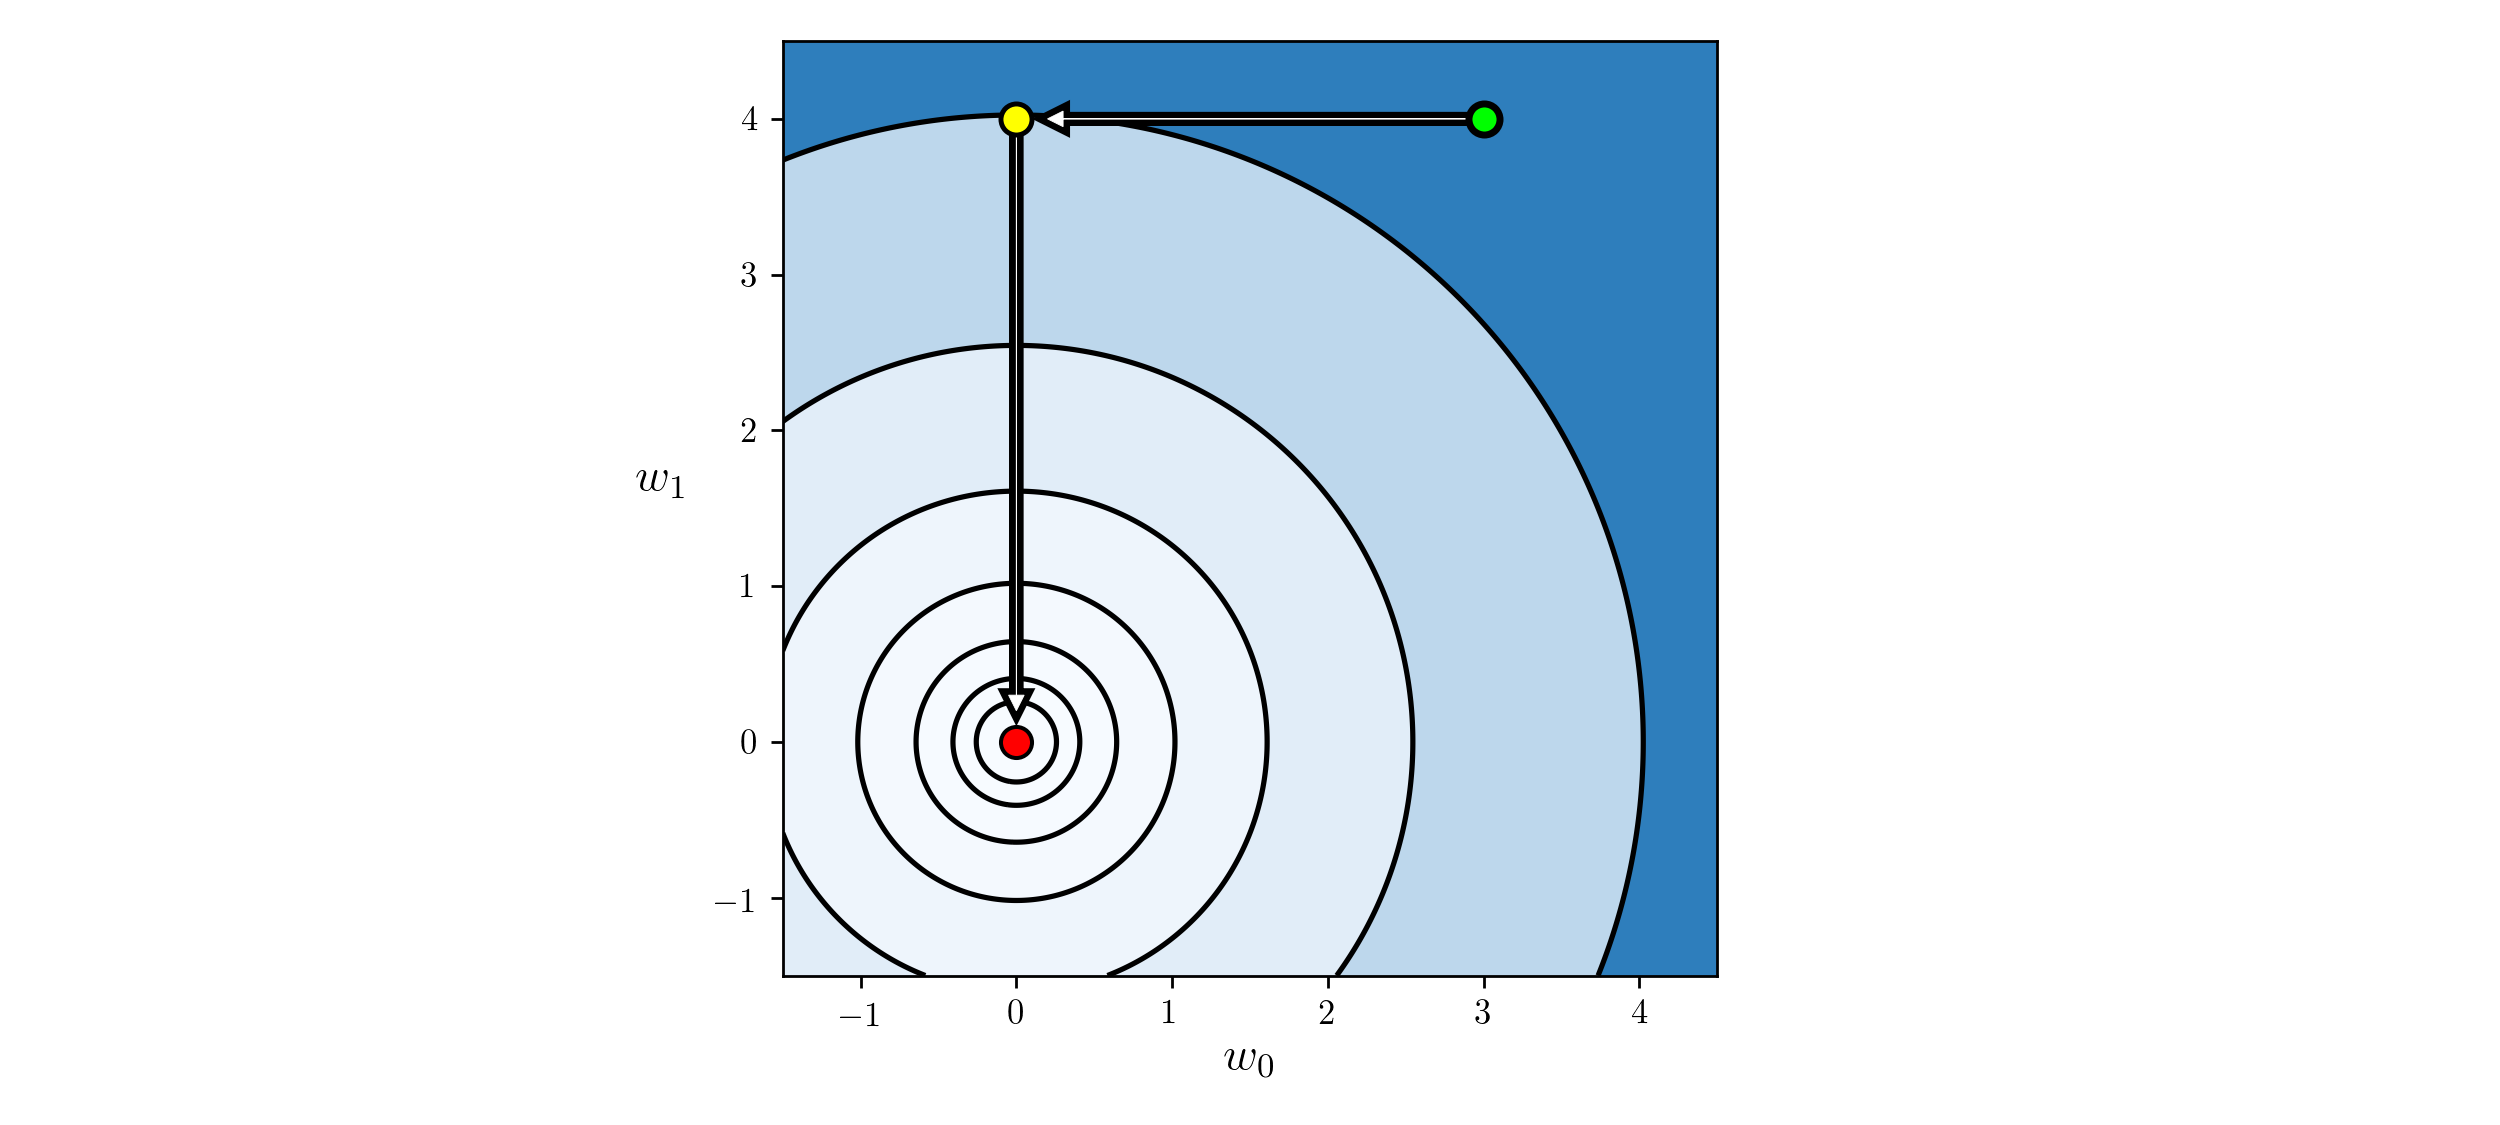

In [29]:
# This code cell will not be shown in the HTML version of this notebook
# define constants for a N=2 input quadratic
a = 2
b = np.zeros((2,1))
C = np.eye(2)

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# initialization
w = np.array([3,4])

# run your alternating descent code
max_its = 1
weight_history,cost_history = coordinate_descent_for_quadratic(g,w,max_its,a,b,C)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 7,show_original = False)

Next we make a run of $2$ iterations of the method at the same initial point to completely minimize another convex quadratic with $a = 20$, $\mathbf{b} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$, and $\mathbf{C} = \begin{bmatrix} 2 \,\, 1 \\ 1 \,\, 2 \end{bmatrix}$. 

<IPython.core.display.Javascript object>


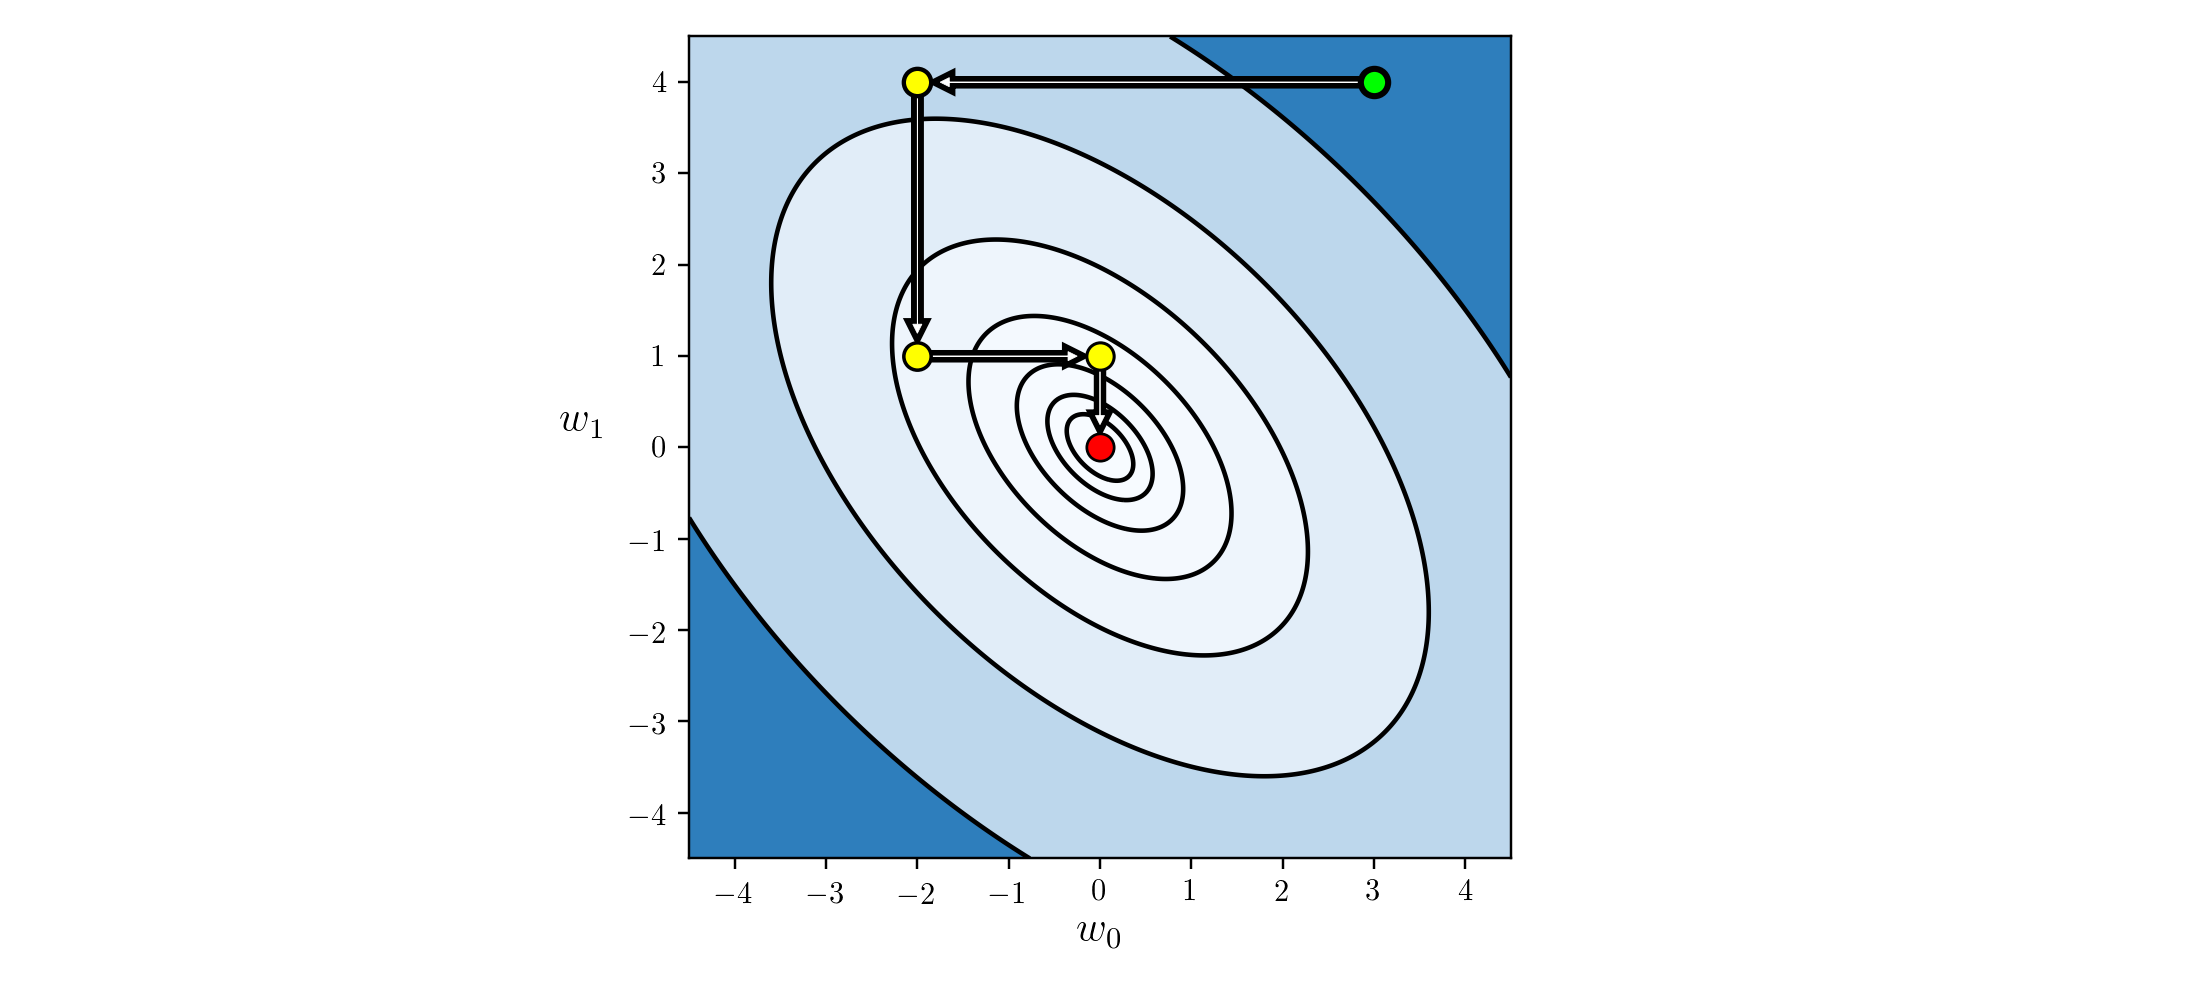

In [33]:
# This code cell will not be shown in the HTML version of this notebook
# define constants for a N=2 input quadratic
a = 20
b = np.zeros((2,1))
C = np.array([[2,1],[1,2]])

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# initialization
w = np.array([3,4])

# run your alternating descent code
max_its = 2
weight_history,cost_history = coordinate_descent_for_quadratic(g,w,max_its,a,b,C)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -4.5,xmax = 4.5,ymin = -4.5,ymax = 4.5,num_contours = 7,show_original = False)

#### <span style="color:#a50e3e;">Example 2:</span>  Solving systems symmetric equations

Note how in the previous example the first order system turned out to be *linear*.  More specifically, we ended up using coordinate descent to solve the linear system (re-arranging equation 

\begin{equation}
\mathbf{C}\mathbf{w} = - \frac{1}{2}\mathbf{b}.
\end{equation}

Here square symmetric $N \times N$ matrix $\mathbf{C}$ and the $N\times 1$ vector $\mathbf{b}$ came from an associated quadratic (and since that quadratic is assumed convex, $\mathbf{C}$ must be *positive semi-definite*, i.e., it must  have all nonnegative eigenvalues).  However, divorced from the concept of a quadratic we can think of coordinate descent in a broader context - as a method for solving more general linear systems of equations where the matrix $\mathbf{C}$ is positive semi-definite.  

Thus we can re-interpret the experiments performed in the previous example in just this way - as examples of coordinate descent applied to solving square linear systems of equations where the matrix $\mathbf{C}$ is positive semi-definite.